# Introduction:

This notebook is a practical example of the steps taken in multivariate linear regression. I tried to be as generic as possible, but in reality, every dataset is unique and requires a slightly different treatment. If you noticed any missing or unnecessary steps don't hesitate to leave a comment :) 

Let's denote the dependent variable as $Y$, and the independent variables (features) $X ~ (x_1, x_2\dots x_n)$.  
 

# 1. Ask the Right Question:
   
The first and foremost is to state the objective of the analysis and be very clear about it. Here we're building a model to predict the price of used BMW given a list of features (age, mileage, color...etc)  
Let's begin by importing the libraries needed. I kept the libraries in a `txt` file so the notebook is tidy!

In [46]:
import os
import numpy as np # linear algebra
from numpy.linalg import inv, det
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as st

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf
from patsy import dmatrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.io as pio 

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(125)
pio.templates.default = 'none'
pio.renderers.default='iframe'

In [2]:
%matplotlib inline

# 2. Read & Clean Data:
The second step is to gather data. But in our case we're using a ready multivariate dataset that contains selling prices of +4800 used BMW cars and their models, mileage, color, fuel type...etc

In [3]:
filename = 'bmw_pricing_challenge.csv'
dirname = '.'

df = pd.read_csv(os.path.join(dirname, filename), parse_dates=['registration_date','sold_at'])
df.head(3)

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01


## 2.1 Examin data types & corrupt data:

Looking at the table above I noticed the following:
- There are 12 categorical and 3 continuous variables (including the dependent variable)
- We can calculate the age of each car at the time of sale from the two date fields `registration_date` and `sold_at`
- I think the car's model is relevant when it comes to predicting price. But the `model_key` column has way too many categories, so I'm going to combine them into fewer values in a new field using the BMW series model.

In [4]:
#Calculate age ~ the time in years between registering the car and selling it
df['age'] = (df.sold_at - df.registration_date).dt.days / 365


#Assign categorical variables
cat_cols = ['model_key', 'fuel','paint_color','car_type',
            'feature_1','feature_2','feature_3','feature_4',
            'feature_5','feature_6','feature_7','feature_8']
cont_cols = ['mileage','engine_power','price','age']

The next step is to examine the continuous $X$ and $Y$ variables:

In [5]:
df[cont_cols].describe()

,mileage,engine_power,price,age
count,4.843000e+03,4843.00000,4843.000000,4843.000000
mean,1.409628e+05,128.98823,15828.081767,5.434862
std,6.019674e+04,38.99336,9220.285684,2.540489
min,-6.400000e+01,0.00000,100.000000,0.589041
25%,1.029135e+05,100.00000,10800.000000,4.079452
50%,1.410800e+05,120.00000,14200.000000,4.835616
75%,1.751955e+05,135.00000,18600.000000,5.835616
max,1.000376e+06,423.00000,178500.000000,28.104110


Right off the bat, mileage cannot be negative and engine power can't be zero! So let's fix them assuming this was a data-gathering error 

In [6]:
# change the sign of mileage to positive

df.mileage = df.mileage.apply(lambda x: abs(x))

In [7]:
# fix the record with zero engine horse power
df[df.engine_power <=0]

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at,age
3765,BMW,X1,81770,0,2014-10-01,diesel,white,suv,False,False,False,False,False,False,False,False,11700,2018-03-01,3.416438


In [8]:
# replace zero engine power with the median of car
df.engine_power[df.engine_power==0] = \
df[(df.model_key =='X1')&(df.fuel =='diesel')&(df.age < 3.5)].engine_power.median()

In [9]:
# check if there is any N/As in the dataset
print(df.isna().sum())

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
age                  0
dtype: int64


**Conclusion:** No N/As to worry about.

## 2.2 Outliers

Sometimes outliers are bad data that you must get rid of, and sometimes they're Michael Jordan or Shaquille O'Neal and you should keep. Either way, outliers must be identified before dealing with them.  
The two most common definitions of outliers are: 
1. Observations that are more than 3 standard deviations away from the mean.
2. Observations that are more than 1.5 * Inter-Quartile-Range (IQR) below/above the 25th/75th percentiles (ends of the boxplot).

**More on outliers detection**   
The most common techniques used to identify outliers by data types is:  
- Univariate data -> boxplot. outside of 1.5 times the inter-quartile range is an outlier.  
- Bivariate -> scatterplot with confidence ellipse. outside of, say, 95% confidence ellipse is an outlier.  
- Multivariate -> Mahalanobis D2 distance   

Once defined, mark those observations as outliers. Then run a logistic regression to see if there are any systematic patterns. 

In [10]:
# We only examin outliers in continuous variables
fig = px.box(df[cont_cols].melt(var_name='variable'),
             color='variable',
             facet_col='variable',
             boxmode='overlay')
fig.update_yaxes(matches=None)
fig.show()

**Conclusion:**
There are some outliers in $X$ and $Y$, but at this point, I'm going to leave them as is. Because they appear to be extreme readings. I will revisit this assumption after building the model though 

## 2.3 Imbalances:

In general, having balanced data results in higher accuracy models. An underrepresented group can lead to an insignificant coefficient.  
This is true for all regression types and machine learning algorithms. 

In [11]:
fig = go.Figure()
for col in cat_cols:
    d = df.groupby(col).size().to_frame(col).T
    f = px.bar(d, orientation='h')
    for o in f.data:
        fig.add_trace(o)
fig.update_layout(showlegend=False, barmode='stack', title='Distribution of Data across Categorical Variables')
fig.show()

Bar plots across categorical variables reveal some underrepresented categories. An obvious example is the small number of petrol and electric cars vs. diesel, which doesn't represent the population!  
Another example is the imbalance between the `paint_color` sub-categories. This is justifiable because some car colors are more popular. Same goes for `key_model` and `car_type` (Convertable, Coupe, subcompacts, and vans)    


**Conclusion**  
Sample data should reflect the population irrespective of how extreme we perceive it. It should also make economic sense! 
One of the consequences is failing coefficient *t-test*, and ending up with insignificant coefficients. To avoid that, I'm going to merge the underrepresented categories into a single one.

In [12]:
# Roll up model_key into model by series
df['model'] = 'Other'
for i in range(1,8):
    idx = df[df.model_key.str.startswith(str(i))].index
    df.model.loc[idx] = str(i) + ' series'
cat_cols.append('model')

# Merge minority colors
df['color'] = np.where(df.paint_color.isin(['beige','green','orange','red']), 'other', df.paint_color)
cat_cols.remove('paint_color')
cat_cols.append('color')
# Drop electric and hybrid cars

df.drop(index=df[df.fuel.isin(['hybrid_petrol','electro'])].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
fig = go.Figure()
cat_cols.remove('model_key')
for col in cat_cols:
    d = df.groupby(col).size().to_frame(col).T
    f = px.bar(d, orientation='h')
    for o in f.data:
        fig.add_trace(o)
fig.update_layout(showlegend=False, barmode='stack', title='Distribution of Data across Categorical Variables')
fig.show()

## 2.4 Relationship between Variables
To examine the relationship between variables we can:
1. scatter plot them
2. calculate their correlation
Let's do both

In [14]:
scatter = ff.create_scatterplotmatrix(df[cont_cols],
                                      diag='histogram',
                                      height=900, width=900,
                                      title='BMW Scatter Plot')
scatter.show()

In [15]:
# pd.plotting.scatter_matrix(df[cont_cols], figsize=(12,12));

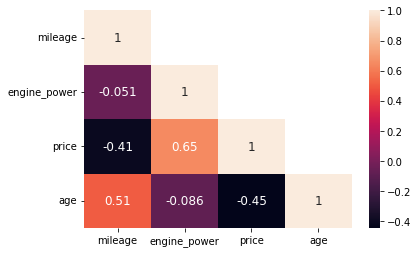

In [16]:
mask = np.ones_like(df[cont_cols].corr(), dtype=bool)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(df[cont_cols].corr(), annot=True, mask=mask, annot_kws=dict(fontsize=12));

**Conclusion**:  
1. None of the continuous variables is normally distributed. Therefore, I don't expect the residuals to be normally distributed either (not without transforming variables that is)
2. There appear to be negative relationships between `price` and each of `mileage` and `age` albeit not straight lines! This is confirmed by their moderate negative correlation of `-0.41` and `-0.45` respectively.

3. Engine power and price have a moderate positive relationship that appears to be linear. This makes economic sense since higher engine power is indicative of more expensive sport or luxury models.
4. There's a moderate positive correlation between the explanatory variables `age` and `mileage`. This makes sense as we expect older cars to have more mileage. This is something to keep an eye on when testing/correcting multicollinearity


# 3. Analyzing Data

This step should answer the question in step (1).i.e. predict BMW cars' prices given a set of their specifications and features. 

### 3.2 Pre-Processing
#### 3.2.1 Split Data

It's standard practice to split the data into training and test sets to see how the model behaves when presented with data it hasn't seen. 

In [47]:
# Split the data into train and test sets

train_idx, test_idx = train_test_split(df.index, test_size=.25)
df_train = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

print(f'Size of training set:{len(df_train)}, size of test set: {len(df_test)}\n')

Size of training set:3624, size of test set: 1208



#### 3.2.2 Normalize data (optional but important)
Normalizing data improves numerical stability and produces cleaner results. It doesn't improve accuracy or prediction power though

In [48]:
# Scale the data (optional)

from sklearn.preprocessing import MinMaxScaler
cont_x = ['mileage','engine_power','age']
scalar = MinMaxScaler()
scalar.fit(df[cont_x])
dfc = df.copy()
dfc[cont_x] = scalar.transform(dfc[cont_x])

dfc_train = dfc.iloc[train_idx].reset_index(drop=True)
dfc_test = dfc.iloc[test_idx].reset_index(drop=True)

#### 3.2.3 Predictor function
It convenient to write an $R^2$ function to test data with later

In [49]:
def pred(res, x, y, log=False):
    y_hat = res.predict(x)
    if log:
        y_hat = np.exp(y_hat)
    r2 = r2_score(y,y_hat)
    print(f'R-squared: {r2:.2f}')

### 3.3 Model Selection
The most challenging step in any analysis is specifying the model to use; is it linear, log-linear, quadratic, or non-linear!? Which variables to omit and which to transform! What kind of transformation (polynomial, log)...etc.   
When it comes to model selection keep in mind that the model's job is to approximate, and not perfectly represent reality. So keep it simple, but not too simple! 
You must be able to explain the relationship in terms of how a unit increase in $X_i$ changes $Y$. And explain the economic sense of the model and how it adheres to its assumptions.  

#### 3.3.1 Manual  approach
It's always good to examine the scatter plot and correlation matrix first to get a sense of the relationship between variables. From there write down an initial formula for the model, and build on it. 

In [50]:
formula_manual = '''
np.log(price)~age+np.power(age,2)+mileage+np.power(mileage,2)+engine_power+model+fuel+color
+feature_1+feature_2+feature_3+feature_4
+feature_5+feature_6+feature_7+feature_8
'''

ols_manual = smf.ols(formula_manual, df_train)
res_manual = ols_manual.fit()
print(res_manual.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     286.9
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:11:43   Log-Likelihood:                -1514.4
No. Observations:                3624   AIC:                             3085.
Df Residuals:                    3596   BIC:                             3258.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.1431 

In [51]:
# R2 of test-data

pred(res_manual, x=df_test, y=df_test.price, log=True)

R-squared: 0.80


### 3.3.1 Forward Model Selection
Another approach is to use a *forward selection* algorithm. It applies brute force to fit all the possible combinations of variables and pick the one/s with the best metrics (AIC, BIC, R2 Adjusted ... etc.)   
The approach is greedy by nature, which means we'll end up omitting some variables the algorithm had included!

In [22]:
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm

class ForwardModelSelector:
    """
    Ordinary Least Square forward selection algorithm. It tries every possible combination of variables in  
    x_cols and stores the resulting metrices in summary_frame
    """
    def __init__(self, x_cols , y_col, df, subset=None, metrics=['aic','bic','rsquared_adj']):
        """
        x_cols: list of the independent variables
        y_col : str represents the dependent variable or a transformation version of it. Takes np.log, center
        or a custom function
        df    : pandas dataframe contains x's and y
        subset: numpy array or pandas indexes to train on subset of the data (training set)
        metrics: list of metrics to save in summary_frame. Default is aic, bic and rsquared_adj
        
        """
        self.x_cols = x_cols
        self.y_col = y_col
        self.df = df
        self.subset = subset
        self.metrics = metrics
        self.res = defaultdict(list)
        self.left = str(y_col) + '~'
        self.n = 0
        pass
    
    def generate_formulas(self):
        """Generate a list of formulas using all possible combinations of x variables"""
        self.formulas = []
        for i in range(1,len(self.x_cols)):
            self.formulas.extend(list(map(' + '.join, combinations(x_cols, r=i))))
        pass
    
    def fit(self):
        """Regress using generated formulas. Results are saved in dataframe"""
        self.generate_formulas()
        for right in tqdm(self.formulas):
            self.n += 1
            f_tmp = self.left + right
            self._update_(f_tmp)
        print(f'Finished trying {self.n} combinations')
        self.frame = pd.DataFrame(self.res, index=self.metrics+['n_variables']).T.reset_index().rename(columns={'index':'formula'})
    
    def _update_(self, formula):
        ols_tmp = smf.ols(formula, self.df, subset=self.subset).fit()
        for m in self.metrics:
            self.res[formula].append(getattr(ols_tmp,m))
        self.res[formula].append(ols_tmp.model.exog.shape[1])
        pass
    
    def summary_frame(self, sort_by=None, ascending=None):
        if sort_by is None:
            return self.frame.sort_values(self.metrics)
        return self.frame.sort_values(sort_by, ascending=ascending)


In [23]:
x_cols = ['age','np.power(age,2)','mileage','np.power(mileage,2)','engine_power'] + cat_cols

m = ForwardModelSelector(x_cols, 'np.log(price)', df, subset=train_idx, metrics=['aic','bic','rsquared_adj','fvalue'])
m.fit()

100%|██████████| 131070/131070 [52:26<00:00, 41.65it/s] 


Finished trying 131070 combinations


The algorithm tried 131,070 combinations of $x$ variables, which are continuous, quadratic, and categorical. Let's list the top 10 by by `rsquared_adj`, `bic` and `aic`, then one that best fits the criteria. In this case, I would choose the model with the highest R-squared adjusted and lowest AIC, BIC with the least number of variables!

In [24]:
top = m.summary_frame(sort_by=['rsquared_adj','bic','aic'],
                ascending=[False,True,True]).nlargest(n=10, columns='rsquared_adj')
top

,formula,aic,bic,rsquared_adj,fvalue,n_variables
131069,"np.log(price)~np.power(age,2) + mileage + np.p...",2808.581484,3019.222829,0.708102,267.329609,34.0
131044,"np.log(price)~np.power(age,2) + mileage + np.p...",2809.342877,3013.788888,0.707961,275.464934,33.0
131048,"np.log(price)~np.power(age,2) + mileage + np.p...",2809.832073,3014.278084,0.707922,275.412605,33.0
131060,"np.log(price)~age + np.power(age,2) + mileage ...",2811.320739,3021.962084,0.707881,267.045422,34.0
131064,"np.log(price)~age + np.power(age,2) + mileage ...",2811.750167,3022.391512,0.707847,267.000890,34.0
130859,"np.log(price)~np.power(age,2) + mileage + np.p...",2810.597965,3008.848642,0.707780,284.070694,32.0
130979,"np.log(price)~age + np.power(age,2) + mileage ...",2812.567177,3017.013188,0.707701,275.120162,33.0
131037,"np.log(price)~np.power(age,2) + mileage + np.p...",2812.735686,2986.205029,0.707287,325.234272,28.0
131053,"np.log(price)~age + np.power(age,2) + mileage ...",2814.720330,2994.385006,0.707207,313.533422,29.0
130818,"np.log(price)~np.power(age,2) + mileage + np.p...",2813.144902,2980.418911,0.707174,337.520745,27.0


The second to last regression have used the smallest number of variables providing almost the same $R^2$, BIC, and AIC. 

In [52]:
formula = top.loc[top.n_variables.idxmin()].formula
formula

'np.log(price)~np.power(age,2) + mileage + np.power(mileage,2) + engine_power + fuel + car_type + feature_1 + feature_2 + feature_4 + feature_5 + feature_6 + feature_7 + feature_8 + model'

In [53]:
ols = smf.ols(formula, data=df, subset=train_idx)
res = ols.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     313.5
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:11:59   Log-Likelihood:                -1451.3
No. Observations:                3624   AIC:                             2957.
Df Residuals:                    3597   BIC:                             3124.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9

In [54]:
# R-squared of test-data

pred(res, x=df_test, y=df_test.price, log=True)

R-squared: 0.81


**Impression**  
Comparing manual and systematic models shows that the forward-selection method has dropped `fuel` and `color` because they didn't improve the chosen metrics. If you remember, in the manual model the two variables had insignificant coefficients. I would've dropped them had I chosen to continue with that approach! This confirms that the algorithm adds value. We can reduce exploration time by building a more efficient search algorithm instead of the brute force one applied here. Like Monte Carlo Tree or A* search to name a few. 
In any event, it doesn't matter which model we begin with. The next steps are very similar in terms of improving and validating it.

That said, let's use the algorithmic output as a base formula for our model.

# 4. Validating the Model

For the model to be valid, it should not violate the assumptions of linear regression. And it has to make economic sense, has significant coefficients, and acceptable performance metrics! In other words, it must be BLUE (Best Linear Unbiased Efficient)

## 4.1 Model Assumptions
The assumptions of Multivariate Linear Regression are:
- MR.1: The population is described by linear model $Y = X\beta + \epsilon$
- MR.2: **Strict Exogeneity**: conditional expectation of error term given all observations is zero: $E(\epsilon |X)=0$
- MR.3: **Conditional homoskedasticity** the variance-covariance matrix of the error term conditional on X is constant
$$Var(\epsilon|X) =\sigma^2.I $$
- MR.4: **Conditional uncorrelated errors** the covariance between different error term pairs, conditional on X is zero:
- MR.5 There exists no exact linear relationship between the explanatory variables. This means that:
$$ rank(X) = K+1$$
$$det(X^TX) \neq 0$$
- MR.6: **(Optional)** the residulas are normally distributed i.e:
$\epsilon|X \in N(0,\sigma^2I$

Each of these assumptions must be validated/tested.  


### 4.1.1 Linearity Tests:
This is the first assumption of linear regression. Breaching it is considered very series because it means the model is not the best representation of the data.  
If the scatter plot between $X$ and $y$ doesn't clearly show the relationship, we revert to numerical methods to test linearity.

#### 4.1.1.2 Harvey-Collier Test for Linearity:
Harvey-Collier performs a t-test on the recursive residuals. If the true relationship is non-linear (i.e. convex or concave) the mean of the recursive residuals is significantly different from zero.  

*$H_0:$ The model is correctly specified as linear*

In [55]:
ols_ordered_tmp = smf.ols('np.log(price)~mileage+age+engine_power', data=df_train).fit()
hc = {'F-statistic':[],'p-value':[]}
idx = []
for col in cont_cols:
    if col =='price':continue
    try:
        h = diagnostic.linear_harvey_collier(ols_ordered_tmp, order_by=np.argsort(df_train[col]))
        idx.append(col)
        hc['F-statistic'].append(h[0])
        hc['p-value'].append(h[1])
        
    except:
        pass
pd.DataFrame(hc, index=idx).round(4)

,F-statistic,p-value
mileage,-0.6379,0.5236
engine_power,-4.3080,0.0000
age,-2.7497,0.0060


#### 4.1.1.3 Rainbow Test for Linearity:
Rainbow test assums that the **true** model is non-linear with additional parameters $Z.\theta$. Where $Z$ is an $r$ x $K$ matrix.  
The hypothesis test to prove linearity is

*$H_0:\theta = 0$ (The model is correctly specificed as linear)*  
*$H_1:\theta \neq 0$*

In [56]:
rainbow = {'F-statistic':[],'p-value':[]}
idx = []
for col in cont_cols:
    if col =='price': continue    
    try:
        h = diagnostic.linear_rainbow(ols_ordered_tmp, order_by=col)
        rainbow['F-statistic'].append(h[0])
        rainbow['p-value'].append(h[1])
        idx.append(col)
    except:
        pass
pd.DataFrame(rainbow, index=idx).style.format('{:.6f}')

,F-statistic,p-value
mileage,0.823809,0.999981
engine_power,0.811053,0.999996
age,1.389998,0.000000


**Impression**
The relationship between `price` and both `mileage` and `engine_power` is correctly specified as linear. However, its relationship with `age` does not appear linear, as the scatter plot shows. That said, we can still build a linear model since the other variables are linear and either omit `age` altogether or leave it as is. The alternative is to build a non-linear algorithm, which is out of the scope of this notebook

In [57]:
# Scatter age and price again and draw a log-normal terndline to visualize the non-linear relation between them

px.scatter(dfc_train, x='age', y='price', trendline='ols', log_y=True, log_x=False, trendline_color_override='red')

### 4.1.2 Heteroskadasticity:

Heteroskedasticity occurs when the variance of the error term is not constant across observations. This breaches assumption MR.3 of linear regression and causes:

- the variance of the estimators to become biased and inconsistent
- the OLS estimator no longer has Student $t$ distribution, which renders *t-test* invalid. Even for large data samples
However, OLS estimators themselves remain unbiased

#### 4.1.2.1 Residual Plot diagram:
Run sequence and vs predicted values, and against each of the independent variable

In [58]:
plot_kwargs = dict(mode='markers',
                   marker=dict(symbol='circle-open', opacity=0.4, size=6, #color='orange', 
                               line=dict(color='orange', width=1)
                              )
                  )

fig = make_subplots(2,3,vertical_spacing=.15,horizontal_spacing=.05,
                   subplot_titles=['Run-Seq','Price Y','Pred Price','Mileage','Age','Engine Power'])
fig.append_trace(go.Scatter(y=res.resid,name='seq-run', **plot_kwargs), 1,1)
fig.append_trace(go.Scatter(x=res.model.endog,name='price (y)', y=res.resid, **plot_kwargs), 1,2)
fig.append_trace(go.Scatter(x=res.fittedvalues,name='predicted price', y=res.resid, **plot_kwargs), 1,3)
fig.append_trace(go.Scatter(x=df.iloc[train_idx].mileage, name='mileage', y=res.resid, **plot_kwargs), 2,1)
fig.append_trace(go.Scatter(x=df.iloc[train_idx].age, name='age', y=res.resid, **plot_kwargs), 2,2)
fig.append_trace(go.Scatter(x=df.iloc[train_idx].engine_power, name='engine_power', y=res.resid, **plot_kwargs), 2,3)

fig.update_layout(height=600)
fig.show()

# plt.plot(res_algo.model.endog,res_algo.resid, 'rx')

**Conclusion**  
Visually, I don't see a particular increasing or decreasing pattern to confirm or deny heteroskedasticity. So let's run some tests

#### 4.1.2.2 Goldfeld-Quandt test:
It's based on two subsamples with two different variances.  
$H_0:$ no heteroskadasticity

In [59]:
def GQ_test(ols, start_idx=None, alpha=0.05):
    GQ = lambda ols,i: diagnostic.het_goldfeldquandt(ols.endog, ols.exog, idx=i, alternative='two-sided')
    gq_df = pd.DataFrame([GQ(ols, i=i) for i in [None]+list(range(start_idx,ols.exog.shape[1]))],
             index=['run-seq']+ols.exog_names[start_idx:],
             columns=['F-statistic','p-value','alternative']
            )
    gq_df['result'] = np.where(gq_df['p-value']< alpha , 'Reject Null Hypothesis', '')
    return gq_df
GQ_test(ols, start_idx=23, alpha=.05)

,F-statistic,p-value,alternative,result
run-seq,0.971489,5.412409e-01,two-sided,
"np.power(age, 2)",0.311864,5.382870e-127,two-sided,Reject Null Hypothesis
mileage,1.170770,8.722418e-04,two-sided,Reject Null Hypothesis
"np.power(mileage, 2)",1.170770,8.722418e-04,two-sided,Reject Null Hypothesis
engine_power,0.950011,2.786379e-01,two-sided,


#### 4.1.2.3 Breusch-Pagan test
This is a general heteroskedasticity test that returns two statistics `LM` and `F-statistic`. Its null hypothesis is: 
$H_0:$ no heterskadasticity at $\alpha$ level.  
We run the test between the residuals and the group of $X$ variables we suspect of being related to heteroskedasticity. In our case, it's `age` and `mileage`, as shown by the GQ test

*Note: p-value can change with different training sets. Sometimes it confirms heteroskedasticity in `age` and `mileage`, other times only `age`*

In [60]:
bp = list(diagnostic.het_breuschpagan(res.resid, df.iloc[train_idx][['age','mileage']].values))
print(pd.DataFrame(bp, index=['LM statistic','p-value','F statistic','p-value'], columns=['Breusch-Pagan']))

              Breusch-Pagan
LM statistic   4.544930e+01
p-value        1.566418e-11
F statistic    2.300056e+01
p-value        1.185451e-10


**Conclusion**Since the p-value is less than $\alpha$ (0.05) We reject the null hypothesis and conclude the presence of heteroskedasticity in `age` and `mileage`

*Note: 

#### 4.1.2.4 White test
Even more generalized test. Its design allows it to include not only exogenous variables but also their polynomial and interaction terms. Its null is: $H_0:$ No heteroskedasticity


In [61]:
white_mat = np.column_stack([np.ones(len(train_idx)), df.iloc[train_idx].age,df.iloc[train_idx].age**2])
diagnostic.het_white(res.resid, white_mat)

(100.67791115670977,
 7.055314809710469e-21,
 25.852969959081303,
 3.707679724341309e-21)


#### 4.1.2.5 How to fix it?
#### 4.1.2.5.A Heteroskadastic-Consistent Errors (HCE):
Also known as white errors. Use them to correct SE, and assess the coefficient's significance. This is a quick and dirty way that often produces variables larger than model-based estimators like WLS, GLS if the residual covariance matrix is correctly specified. However, it's very useful when the shape of heteroskedasticity is unknown.  
All we need to do is fit the model using one of the robust `cov_type`s, then use the new coefficient standard errors and p-values

In [62]:
print(res.get_robustcov_results('HC0').summary().tables[1])

                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9.2191      0.087    105.707      0.000       9.048       9.390
fuel[T.petrol]            -0.0951      0.030     -3.183      0.001      -0.154      -0.037
car_type[T.coupe]         -0.1524      0.079     -1.928      0.054      -0.307       0.003
car_type[T.estate]        -0.3536      0.074     -4.779      0.000      -0.499      -0.208
car_type[T.hatchback]     -0.1495      0.071     -2.101      0.036      -0.289      -0.010
car_type[T.sedan]         -0.1750      0.075     -2.327      0.020      -0.322      -0.028
car_type[T.subcompact]    -0.1129      0.076     -1.493      0.136      -0.261       0.035
car_type[T.suv]           -0.2374      0.135     -1.753      0.080      -0.503       0.028
car_type[T.van]           -0.3950      0.112     -3.514      0.000      -0.615      -0.175

/home/ayman/anaconda3/envs/stats/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 26, but rank is 25



#### 4.1.2.5.B Weighted Least Squares (WLS)
I'm not going to get into the math of WLS, but it is a special case of Generalized Least Squares (GLS) that assumes no autocorrelation. i.e. covariance matrix is diagonal that has *some* form of heteroskedasticity! Feasible GLS Procedure:
1. Estimate the regression via OLS
2. Calculate $log(\epsilon^2)$
3. estimate the regression $log(\epsilon^2)=X\alpha+v_i$ and calculate the fitted values.
4. Take the exponent of fitted values $\hat{h_i}=e^{\hat{log(\epsilon_i^2)}}$
5. Estimate regression $Y=X\beta + \epsilon$ via WLS using weights $w_i^{-1}=1/\sqrt{\hat{h_i}}$

In [63]:
# Calculate weights array: h_est
log_e2 = np.log(res.resid**2)
e2_mat = df.iloc[train_idx].copy()
e2_mat['log_e2'] = log_e2
f_e2 = 'log_e2~age + np.power(age,2) + mileage + np.power(mileage,2) + engine_power + car_type + feature_1 + feature_2 + feature_4 + feature_5 + feature_6 + feature_7 + feature_8 + model'
h_est = np.exp(smf.ols(formula=f_e2, data=e2_mat).fit().fittedvalues)

# Build GLS model using residual weights
wls = smf.wls(ols.formula, data=df.iloc[train_idx],weights=1/h_est)
res_wls = wls.fit()

# Test Heteroskedactisity in WLS
bp_wls = list(diagnostic.het_breuschpagan(res_wls.wresid, df.iloc[train_idx][['age','mileage']].values))
print(pd.DataFrame(bp_wls, index=['LM statistic','p-value','F statistic','p-value'], columns=['Breusch-Pagan']))

              Breusch-Pagan
LM statistic   3.269849e+01
p-value        1.076208e-08
F statistic    1.648900e+01
p-value        7.435716e-08


**Conclusion**: using WLS decreased heteroskedasticity but it didn't eliminate it. This is mainly because we don't know the true form of heteroskedasticity in residuals. In practice, it's acceptable to use white corrected standard errors (Hansen method) 

### 4.1.3 Multicollinearity:

Is the situation in which two or more explanatory variables are highly **linearly** correlated. This is a violation of assumption MR.5 of linear regression that causes the determinant of $(X^T.X)$ matrix to be zero, which results in an invertible matrix. However, In real life, such a relationship is almost always approximate (never perfect), and therefore $det(X^TX)$ is close to zero. The consequences are:

- Imprecise estimators
- Large coefficient standard errors -> failure to reject their significance
- Small changes to input data can lead to big changes in the model (even different signs of the coefficients). This can be examined using cv training
- The usual interpretation of the change in one variable holding all else equal does not hold anymore
- Overfitting, since the variables contain the same data (or partially the same)


#### 4.1.3.1 How to detect it?
The obvious red flags are large F-statistic accompanied by insignificant coefficients (small p-values) and big changes in coefficients when training on different data blocks.

1. $det(X^TX) \neq 0$  
2. $(X^TX)^{-1}(X^TX)=I \neq 0$
3. Correlation between variables
4. **Variance Inflation Factor**: runs a regression between the selected $X_i$ and other independent variables and claculates $VIF=1/(1-R^2)$. Any value above 10 is not good, below 5 is acceptable

We've examined the correlation matrix in step 2.4 and found a moderate positive association between `age` and `mileage`, which might indicate multicollinearity!  
However, what I'm more concerned about is the second warning of regression summary:  
`[2] The condition number is large, 1.04e+12. This might indicate that there are
strong multicollinearity or other numerical problems.`  

So let's run the standard collinearity tests then try to address the condition number by normalizing data. This can address collinearity and other numerical problems.

In [64]:
# 1. determinant matrix
X = res.model.exog
det(X.T@X)

2.2834584260273695e+101

In [65]:
# 2. (X.T@X)^-1 @(X.T@X) = I
np.diag(np.round(inv(X.T@X)@(X.T@X), 7))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The first two tests don't show any signs of multicollinearity but to be on the safe side let's run a variance influence factor test on the continuous variables `age`, `mileage`, and `engine_power`. We are not concerned about the artificial multicollinearity that results from a polynomial transformation of independent variables

In [66]:
#Let's define a function to calculate Variance Influence Factor
def vif_test(ols, cont_cols:list =None):
    """
    VIF test for collinearity of specific continuous variables
    Inputs:
    ols: ordinary least square model (statsmodels)
    cont_cols: list contains the column numbers of variables you want to test
    """
    if cont_cols is None:
        cont_cols = list(range(ols.exog.shape[1]))
    index = [ols.exog_names[n] for n in cont_cols]
    vif = lambda ols, i: variance_inflation_factor(ols.exog, exog_idx=i)
    return pd.DataFrame([vif(ols,i) for i in cont_cols], index=index, columns=['VIF'])

vif_test(ols, [22,24,26])

,VIF
model[T.Other],32.573577
mileage,4.409732
engine_power,2.314406


`age` is showing moderate collinearity but before we take an action let's normalize that data to see if that helps. To do that we can either use 

In [67]:
def norm(x):
    return (x-x.mean())/x.std()

formula_n = '''
np.log(price) ~ norm(age) + np.power(norm(age),2) + norm(mileage) + np.power(norm(mileage),2) +
norm(engine_power) + car_type + feature_1 + feature_2 + feature_4 + feature_5 + feature_6 +
feature_7 + feature_8 + model
''' 
ols_norm = smf.ols(formula=formula_n, data=df, subset=train_idx)
res_norm = ols_norm.fit()
summary = res_norm.summary()
print(summary.tables[1],'\n',summary.extra_txt)
vif_test(ols_norm, [22,24,26])

                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.1319      0.074    124.040      0.000       8.988       9.276
car_type[T.coupe]             -0.1391      0.074     -1.874      0.061      -0.285       0.006
car_type[T.estate]            -0.3372      0.068     -4.941      0.000      -0.471      -0.203
car_type[T.hatchback]         -0.1388      0.068     -2.048      0.041      -0.272      -0.006
car_type[T.sedan]             -0.1595      0.068     -2.344      0.019      -0.293      -0.026
car_type[T.subcompact]        -0.1023      0.078     -1.304      0.192      -0.256       0.051
car_type[T.suv]               -0.1826      0.090     -2.024      0.043      -0.359      -0.006
car_type[T.van]               -0.3716      0.126     -2.941      0.003      -0.619      -0.124
feature_1[T.True]              0.0769      0.014  

,VIF
norm(age),3.657385
norm(mileage),1.755274
norm(engine_power),2.270638


**Conclusion**: normalizing data has fixed the condition number and improved the significance of the `age` coefficient. It also reduced its VIF number below 5 which is within the normal range

In [68]:
# Testing R2
pred(res_norm, x=df_test, y=df_test.price, log=True)

R-squared: 0.81


### 4.1.4 Autocorrelation
Serial or autocorrelation is when error terms are correlated with a lagged version of themselves. In this case the covariance matrix remains diagonal with $\sigma$ but the $Cov(\epsilon_i,\epsilon_j) \neq 0$  
The consequences of this are:
- OLS estimators are not efficient (do not minimize the loss function) 
- The variances of the estimators are biased and inconsistent
- Invalid *t-statistics* of OLS estimators (i.e. wrong p-values)

However, the estimators themselves remain unbiased (i.e. the distance between expected and true values)   

The **General approach** to deal with autocorrelation usually follows the below steps:   

1. Assume the true model is $Y=\beta.X+\epsilon$
2. Create a new model using OLS residuals. For example, the residual auxiliary regression in the Breusch-Godfrey test includes the explanatory variables from the original model and n lagged residuals: 
$$\hat{\epsilon_i}^2 = \alpha_0 + \alpha_1X_{1,i}+\dots +\alpha_k X_{k,i}+\rho_1 \hat{\epsilon}_{i-1}^2+\rho_2 \hat{\epsilon}_{i-2}^2+\dots+ \rho_p \hat{\epsilon}_{i-p}^2 + \mu_t$$
3. Test the null hypothesis that the residuals are serially correlated using OLS residual auxiliary regression:
$$H_0: \rho_1=\rho_2=\dots=\rho_p=0$$
4. If we fail to reject the null hypothesis -> use the usual OLS estimators from step 1.
5. If we reject the null hypothesis there are three ways to go about it:  
    a. Continue to use the OLS estimators but correct their variance (i.e. make them consistent)  
    b. Instead of OLS, use FGLS (and its variations).  
    c. Specify a different model that, hopefully, accounts for serial correlation

#### 4.1.4.1 How to detect it:
We start with a residual correlogram plot, and if it didn't show clear relation we move to numerical tests. The most common of which are **Durbin-Watson** and **Breusch-Godfrey** tests. Both assume no serial correlation at $\alpha$ level

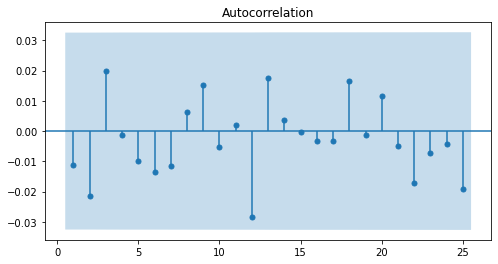

In [69]:
# There is a built in fuction in statsmodel and another in pandas plotting
fig = plt.figure(figsize=(8,4))
plot_acf(res_norm.resid, lags=25, zero=False, ax=fig.add_subplot(111));
plt.show()

In [70]:
names = ['LM-stat','LM:p-value','F-stat','F:p-value']
pd.DataFrame(diagnostic.acorr_breusch_godfrey(res_norm, nlags=20), index=names, columns=['Breusch-Godfrey'])

,Breusch-Godfrey
LM-stat,12.049052
LM:p-value,0.914377
F-stat,0.596623
F:p-value,0.918039


In [71]:
# Durbin Watson:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(res_norm.resid)

2.022144318406277

**Conclusion** examining the correlogram plot, BG and DW number, shows no signs of autocorrelation in our residuals at the 20th lag



# Appendex
Here are some important definitions and explanations of regression outputs often used in statistical analysis.

#### Bias of Estimator
Bias is a measure of the difference between the estimator's expected and true values. As such, a biased estimator is one with coefficients that are very different from the true values 

#### Efficiency of Estimator
An efficient estimator is the 'best possible' estimator of the parameter of interest that minimizes the loss function. In linear regression, it's the parameter that provides the smallest variance.

#### 7.1 R-squared
R-squared/Adj.R-squared: 90.4% of the variability in the dependent variable is explained by the independent variables. This is high enough for the training set, but let's see how well the model deals with data it hasn't seen (test_set)
Test R-squared at 90.5% is as high as train R-squared, which means the model generalizes well


#### 7.2 F-statistic|Prob(F)
It tests how well the independent variables as a group explain the variations in the dependent variable (i.e. tests the null hypothesis $H_0: \beta_1=\beta_2=\dots \beta_n=0$   
P-value of F-statistic, or the probability of type I error (observation happening giving the null hypothesis is true)  
In this case, F-statistic is very large and Prob(F) is zero, which is great!  

#### 7.3 AIC:
The Akaike Information Criterion (AIC) measures overfit. It rewards the model for goodness-of-fit and penalizes it if it became overly complicated.  
AIC is useful when comparing models but very hard to interpret standalone!  

#### 7.4 Omnibus/Prob(Omnibus):
Tests the normality of the residuals. We hope to see a value close to zero for the Omnibus number and a value close to one for the Prob (Omnibus).
**Omnibus: the closer to zero the better***  
**Prob(Omnibus): The closer to one the better***  

In this case, Omnibus is relatively high and the Prob (Omnibus) is relatively low so the data is far from normal. 

#### 7.5 Skew 
Measures data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus.  
**The closer to zero the better***   

#### 7.6 Kurtosis
A measure of peakiness, or data curvature. Higher peaks lead to greater Kurtosis, and in the case of residuals, a greater Kurtosis means tighter clustering around zero, which implies a better model with few outliers.  
**The higher the better**  

#### 7.7 Durbin-Watson
Tests for serial correlation. A value between 1.5 and 2.5 means there is no serial correlation. In this case, the number is within the acceptable range.  

#### 7.8 Jarque-Bera (JB)/Prob(JB)
Like the Omnibus test, it measures both skewness and kurtosis. We hope to see in this test confirmation of the Omnibus test.   

#### 7.9 Condition Number
Measures the sensitivity of a function's output as compared to its input. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30.  
**The smaller below 30 the better**


Good reading on regression violations and how to correct them:  
https://people.duke.edu/~rnau/testing.htm
